# 가설 검정을 통한 카카오 주식 매매 백테스팅

데이터 분석은 가설 검정의 연속이다. 굳이 분석 속도를 늦추며 가설 검정을 하는 이유는 데이터를 바라볼 때 가능한 주관과 직감을 배제하기 위함이며 분석의 방향을 잃지 않도록 단계별로 구체적인 '목적'을 가지기 위함이다. <br><br>
가설 검정을 통해 데이터를 분석하는 습관을 기르면 처음에는 속도가 더딜지라도 **결국 정확하고 객관적이며 빠른 속도로 결론에 도달할 수 있다.**<br><br>
따라서 본문을 통해 작은 고민도 가설을 세우고 객관적으로 풀어가는 연습을 하고자 한다.

목차:

```
Step 1. 카카오 주식을 1999년 11월 11일에 100만원 치 샀다면 오늘 얼마일까?
     1-1. 라이브러리 호출 및 데이터 확인
     1-2. 가설 검정
Step 2. 카카오 주가는 언제나 상승장이었을까?
     2-1. 가설 검정(일봉 차트)
     2-2. 가설 검정(365일 이동평균선)
Step 3. 수면제 먹고 자는 것보다 더 나은 수익을 낼 수 있을까?
     3-1. 이동 평균 데이터 추가
     3-2. 데이터 전처리(change 컬럼)
     3-3. 백테스팅 전략 설계
     3-4. 데이터 전처리(매매 구간 처리 - overs 컬럼)
     3-5. 데이터 전처리(매매 신호 표기 - signal 컬럼)
     3-6. 가설 검정(매입액 현재가 비교)
```

## 1. 카카오 주식을 1999년 11월 11일에 100만원 치 샀다면 오늘 얼마일까?

예상컨데 엄청난 돈이 되었을 것이다. 그런데 정확히 얼마가 되었을 지 궁금하지 않은가? 이러한 작은 고민에서도 가설 검정을 시작해볼 수 있다.

### 1-1. 라이브러리 호출 및 데이터 확인

먼저 우리가 사용할 라이브러리를 불러온다.

1. 데이터 확보를 위해 금융 데이터를 편하게 가져올 수 있는 `FinanceDataReader`를 사용할 것이고, 
2. 데이터프레임이라는 파이썬 자료형을 편하게 다루기 위해 `pandas`를 사용한다. 
3. 마지막으로 시각화를 위해 `matplotlib`과 `seaborn`패키지를 사용하며 
4. 주피터노트북에서 종종 나타나는 불필요한 경고를 숨기기 위해 `warnings`패키지도 사용하겠다.(치명적이라면 경고가 아니라 에러가 바로 뜨고 코드가 실행되지 않으니 걱정하지 말자)



In [206]:
import FinanceDataReader as fdr

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['classic']) # 테마: 주식 차트 느낌내기

import warnings
warnings.filterwarnings(action='ignore')

다음으로 카카오 종목코드를 인자로 넣어서 카카오 주가 정보를 확보한다.

In [207]:
stock_kakao = fdr.DataReader('035720')
stock_kakao

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-11-11,999,999,999,999,12,NaN
1999-11-12,1115,1115,1115,1115,140,0.116116
1999-11-15,1249,1249,1249,1249,405,0.120179
1999-11-16,1396,1396,1396,1396,214,0.117694
1999-11-17,1561,1561,1561,1561,191,0.118195
...,...,...,...,...,...,...
2021-09-01,155000,156000,154000,154000,2011434,-0.006452
2021-09-02,154500,156000,153500,155000,1649156,0.006494
2021-09-03,155500,157500,154500,156500,1934669,0.009677


### 1-2. 가설 검정

카카오 주식을 1999년 11월 11일에 100만원 치 샀다면 오늘 얼마일까?

일반적인 수준에서 "100배 올랐다" 하면 주식으로 정말 많이 벌었다고 할 수 있다. 
- 귀무가설) 카카오 주가는 100배 혹은 그 미만으로 올랐다
- 연구가설) 카카오 주가는 100배를 초과하여 올랐다


In [208]:
# 오타 방지를 위해 컬럼명 소문자로 변경
stock_kakao.columns = stock_kakao.columns.str.lower()
stock_kakao.columns

Index(['open', 'high', 'low', 'close', 'volume', 'change'], dtype='object')

In [209]:
# 수익 계산을 위해 첫날 주가로 전체 종가 나누기 
stock_kakao['yield'] = stock_kakao['close']/stock_kakao['close'][0]

# 첫날 매입한 카카오 주식의 총 가격을 100만원으로 환산
stock_kakao['yield'] *= 1000000

# 소수점 이하 제거
stock_kakao['yield'] = stock_kakao['yield'].astype('int64')
stock_kakao['yield']

# 보기 쉽게 '천' 단위 구분자 포함된 문자열로 변환
# ## ex) 1.000000e+06 --> "1,000,000.0"
stock_kakao['yield'] = stock_kakao['yield'].apply(lambda x : '{:,}'.format(x))
stock_kakao['yield']

Date
1999-11-11      1,000,000
1999-11-12      1,116,116
1999-11-15      1,250,250
1999-11-16      1,397,397
1999-11-17      1,562,562
                 ...     
2021-09-01    154,154,154
2021-09-02    155,155,155
2021-09-03    156,656,656
2021-09-06    155,655,655
2021-09-07    154,154,154
Name: yield, Length: 5389, dtype: object

새 천년이 시작하기 직전에 카카오 주식을 100만원치만 사놓고 잊고 지냈다면 지금쯤 1억 5천만원을 벌었다. **150배 넘개 올랐기 때문에 귀무가설을 기각한다.**

## 2. 카카오 주가는 언제나 상승장이었을까?

주가가 매입 금액 대비 150배가 올랐다면 쉬지 않고 주가가 올랐을 것만 같다.(카카오가 코로나사태 이후 급상승한 것은 알아도 모르는 척 하자 우리는 직감과 경험을 최대한 배제한다.) 이것을 어떻게 데이터로 확인할 수 있을까? 

### 2-1. 가설 검정(일봉 차트)

먼저 단순히 일봉 차트를 그려볼 수 있다. 다시 말하지만 직감적으로 하루 정도는 주가가 빠졌을 것이라 생각할 수 있지만 직감을 완벽히 배제한다. 

- 귀무가설) 카카오 주가는 하루도 빠짐없이 올랐다.
- 연구가설) 카카오 주가는 최소 하루 이상 내렸다.

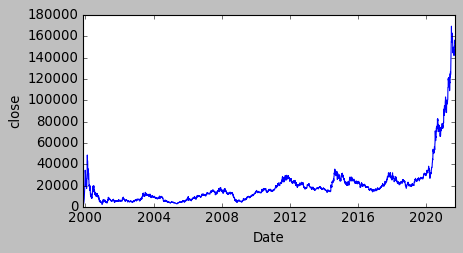

In [188]:
# 그래프 가로로 길게 수정
plt.figure(figsize=(6,3))

# x축은 날짜(Index), y축은 종가(close 컬럼)로 해서 선형 그래프를 그려본다.
sns.lineplot(x=stock_kakao.index, y=stock_kakao['close']);


주가의 자잘한 오르내림을 수도 없이 볼 수 있다. **귀무 가설을 기각한다.** 그렇다면 하루 이틀이 아니라 전체 기간의 주가 추세는 어땠을까? 그 전에, 그런 주가 추세를 데이터로 어떻게 볼 수 있을까?

### 2-2. 가설 검정(365일 이동평균선)


우리에게 익숙한 '이동평균선'을 활용하면 된다. '이동평균선'은 말그대로 n일간 주가 평균의 움직임을 말한다. 여기서 몇 일을 기준으로 할 것인가는 중요하다. 너무 적은 숫자(20일, 30일) 안에서는 등락이 클 것이기 때문에 "최소 연간 평균치의 움직임은 항상 상승했을 것이다" 라는 기준으로 이동평균선을 확인해보는 것이 좋다.<br><br>

예시에 따라 365일 평균 데이터를 들여다보자.


- 귀무가설) 카카오 주가의 365일 이동평균선은 항상 상승했다.
- 연구가설) 카카오 주가의 365일 이동평균선은 항상 상승하지 않았다.(내리막이 있었다.)

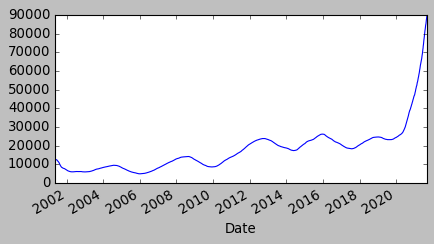

In [189]:
# 그래프 가로로 길게 수정
plt.figure(figsize=(6,3))

# 300일 이동평균 데이터 확보
kakao_moving_avg_365 = stock_kakao['close'].rolling(window=365).mean()

# 300일 이동평균 데이터는 지난 300일간 주가를 평균낸 데이터다.
# 따라서 가장 앞의 299일치 데이터는 NaN으로 처리된다.
# 그래프를 그리기 위해 NaN값을 제거한다.
kakao_moving_avg_365 = kakao_moving_avg_365.dropna()

# 300일 이평선을 그린다
kakao_moving_avg_365.plot();


카카오는 안타깝게도 최소 2019년까지(굉장히 최근이다) ~~개잡주~~라 불리며 고통 받았을 것만 같다. 그러나 끝까지 믿어준(코로나로 떡락할때까지도) 우리 주주들에게 "기다려주셔서 감사합니다"하고 선물하듯 수직 상승 하고있다.

2019년~2020년 초까지 고통받은 고통받은 카카오 주주들을 위로하며 **귀무가설을 기각한다.**

## 3. 수면제 먹고 자는 것보다 더 나은 수익을 낼 수 있을까?

처음 100만원치 사놓고 가만히 놔뒀더니 1억 5천을 벌었다. 그런데도 사람들은 단타, 자동매매, 차트매매 등 현란한 설명과 기술을 써가며 더 높은 수익을 얻기 위해 노력한다.<br>
이번에는 자동매매라 생각하고 일반적으로 높은 수익을 얻을 수 있을 것이라 생각하는 골든크로스 매수, 데드크로스 매도 전략을 백테스팅해보고 수면제 먹고 잔 결과(앞의 사례, 150배)보다 더 나은지 알아보려고 한다.<br><br>

참고로 골든크로스는 단기 이동평균선(상대적, 보통 20일 이하)이 장기 이동평균선(상대적, 보통 30일 이상)을 뚫고 올라가는 양상을 말하며,<br>
반대로 데드크로스는 단기 이동평균선이 장기 이동평균선을 뚫고 내려가는 양상을 말한다. <br><br>


'골든크로스는 상승 추세에서 나타나야 의미가 있다'부터해서 구체적이고 현란한 차트 스킬들이 많다고 한다. 하지만 주식 배우는 글이 아니기 때문에 굳이 더 복잡하게 매매 전략을 설계하지 말고 **단기 이동 평균선이 장기 이동평균선을 역전해서 올라가는 순간 1주 매수하고 그 반대가 되는 순간 1주 매도하는 전략**을 취하는 것으로 논의를 단순화하자.


### 3-1. 이동 평균 데이터 추가

전략을 코드로 구현하기 위해 먼저 단기 이동 평균 데이터와 장기 이동 평균 데이터를 rolling()함수를 통해 확보한다. 인자 5를 넣으면 5일 이동평균을 계산한다.

In [190]:
# 5일 이동평균 데이터(단기)
stock_kakao['short_window'] = stock_kakao['close'].rolling(5).mean()
# 30일 이동평균 데이터(장기)
stock_kakao['long_window'] = stock_kakao['close'].rolling(30).mean()

# 이동평균 데이터가 존재하지 않으면 매매할 수 없기 때문에(전략상) 데이터가 없으면(최초 30일 미만) 제거한다.
stock_kakao.dropna(inplace=True)

# 이동평균 데이터(장기) -> 평균이므로 소수점 이하 생김 -> int형으로 변환해서 소수점 제거
stock_kakao['short_window'] = stock_kakao['short_window'].astype('int64')
stock_kakao['long_window'] = stock_kakao['long_window'].astype('int64')

stock_kakao

,open,high,low,close,volume,change,yield,short_window,long_window
Date,,,,,,,,,
1999-12-22,20522,21950,20522,21950,504048,0.118186,"21,971,971",18952,7519
1999-12-23,24583,24583,23735,24583,137005,0.119954,"24,607,607",20567,8305
1999-12-24,24493,27527,23199,27527,306559,0.119758,"27,554,554",22610,9185
1999-12-27,27215,30829,26635,30829,363146,0.119955,"30,859,859",24903,10171
1999-12-28,32613,34487,31765,34487,179437,0.118655,"34,521,521",27875,11274
...,...,...,...,...,...,...,...,...,...
2021-09-01,155000,156000,154000,154000,2011434,-0.006452,"154,154,154",152000,147783
2021-09-02,154500,156000,153500,155000,1649156,0.006494,"155,155,155",153100,148116
2021-09-03,155500,157500,154500,156500,1934669,0.009677,"156,656,656",154400,148416


### 3-2. 데이터 전처리(change 컬럼)

change 컬럼(등락율)의 숫자가 길어서 보기가 좋지 않다. 보기 쉽게 소수점 이하 2자리까지만 남기자.

In [191]:
stock_kakao['change'] = stock_kakao['change'].apply(lambda x : '{:.2f}'.format(x))
stock_kakao

,open,high,low,close,volume,change,yield,short_window,long_window
Date,,,,,,,,,
1999-12-22,20522,21950,20522,21950,504048,0.12,"21,971,971",18952,7519
1999-12-23,24583,24583,23735,24583,137005,0.12,"24,607,607",20567,8305
1999-12-24,24493,27527,23199,27527,306559,0.12,"27,554,554",22610,9185
1999-12-27,27215,30829,26635,30829,363146,0.12,"30,859,859",24903,10171
1999-12-28,32613,34487,31765,34487,179437,0.12,"34,521,521",27875,11274
...,...,...,...,...,...,...,...,...,...
2021-09-01,155000,156000,154000,154000,2011434,-0.01,"154,154,154",152000,147783
2021-09-02,154500,156000,153500,155000,1649156,0.01,"155,155,155",153100,148116
2021-09-03,155500,157500,154500,156500,1934669,0.01,"156,656,656",154400,148416


### 3-3. 백테스팅 전략 설계

기존 데이터 테이블에 단기 이동평균 데이터와 장기 이동평균 데이터를 추가했다.
이제 백테스트 코딩 전에 매매 전략을 다시 설명하면, 위 데이터 프레임에서 각 날짜(인덱스)별로 short_window가 long_window를 역전 상승하는 지점에서 '종가'(close)에 매수하고, short_window가 long_window를 역전 하강하는 지점에서 '종가'(close)에 매도할 것이다. **즉, 아래 차트에서 파란색 선이 초록색 선을 넘은 가운데 기간만 주식을 가지고 있는 것이다.**

[]

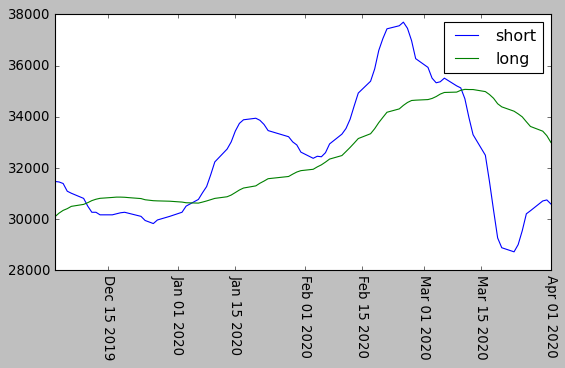

In [192]:
plt.figure(figsize=(8,4))

plt.plot(stock_kakao.loc['2019-12-01':'2020-04-01','short_window'], label='short')
plt.plot(stock_kakao.loc['2019-12-01':'2020-04-01','long_window'], label='long')


plt.legend()
plt.xticks(rotation='270')
plt.plot()

### 3-4. 데이터 전처리(매매 구간 처리 - overs 컬럼)

생각해보자. 파란색 선(단기 이평선)이 초록색 선(장기 이평선)을 넘어 있는 구간을 어떻게 조회할 수 있을까?
동일한 날짜에 short_window 데이터와 long_window 데이터의 크기 차이를 비교하면 된다.

In [193]:
overs = stock_kakao['short_window'] > stock_kakao['long_window']
overs

Date
1999-12-22    True
1999-12-23    True
1999-12-24    True
1999-12-27    True
1999-12-28    True
              ... 
2021-09-01    True
2021-09-02    True
2021-09-03    True
2021-09-06    True
2021-09-07    True
Length: 5360, dtype: bool

우리가 주식을 들고 있으면 좋을 것 같은 구간이 True로 표시되어 있다. "좋을 것 같다"라고 표현한 이유는 True라고 표기된 모든 날짜에 주식을 가지고 있으면 안되기 때문이다.
우리는 해당 날짜의 단기 이동 평균이 장기 이동 평균을 넘어서는 순간 매수할 것이다. 그리고 그 반대가 될 때 매도해야 한다. 위 데이터를 보면 1999년 12월 22일부터 단기 이동평균이 장기 이동평균을 넘어서있다. '상승 역전'의 날이 아니기 때문에 매수하면 안된다. 우리는 False에서 True로 바뀌는 순간 매수하고, True에서 False로 바뀌는 순간 매도한다.

단, True, False보다는 숫자를 사용해보자. 컴퓨터는 0, 1과 친하다. 우리도 컴퓨터를 잘 다루려면 컴퓨터의 친구들과도 친해질 필요가 있다. <br>
0과 1을 사용해 주식을 들고 있을(파란색 선>초록색 선) 구간을 1로, 그렇지 않은 나머지 구간을 0으로 표기한다. 여기서는 약간의 트릭(?)을 사용하는데, 자료형을 int로 바꿔주면 알아서 숫자로 변한다.


In [194]:
overs = overs.astype('int64')
overs

Date
1999-12-22    1
1999-12-23    1
1999-12-24    1
1999-12-27    1
1999-12-28    1
             ..
2021-09-01    1
2021-09-02    1
2021-09-03    1
2021-09-06    1
2021-09-07    1
Length: 5360, dtype: int64

이제 데이터를 stock_kakao 데이터프레임에 추가한다.

In [195]:
stock_kakao['overs'] = overs
stock_kakao

,open,high,low,close,volume,change,yield,short_window,long_window,overs
Date,,,,,,,,,,
1999-12-22,20522,21950,20522,21950,504048,0.12,"21,971,971",18952,7519,1
1999-12-23,24583,24583,23735,24583,137005,0.12,"24,607,607",20567,8305,1
1999-12-24,24493,27527,23199,27527,306559,0.12,"27,554,554",22610,9185,1
1999-12-27,27215,30829,26635,30829,363146,0.12,"30,859,859",24903,10171,1
1999-12-28,32613,34487,31765,34487,179437,0.12,"34,521,521",27875,11274,1
...,...,...,...,...,...,...,...,...,...,...
2021-09-01,155000,156000,154000,154000,2011434,-0.01,"154,154,154",152000,147783,1
2021-09-02,154500,156000,153500,155000,1649156,0.01,"155,155,155",153100,148116,1
2021-09-03,155500,157500,154500,156500,1934669,0.01,"156,656,656",154400,148416,1


### 3-5. 데이터 전처리(매매 신호 표기 - signal 컬럼)

컬럼에 또 하나 추가해서 매수, 매도 지점을 표기할 것이다. 매수는 1, 매도는 -1로 표기하고 매매 포인트가 아닌 날짜는 0으로 표기한다.

In [196]:
# 해당 날짜에 overs가 1이고 그 전날 overs가 0이면 매수 포인트다. 매수 신호 1을 준다.
buy_signal = (stock_kakao['overs'] == 1) & (stock_kakao['overs'].shift(1) == 0)
buy_signal = buy_signal.astype('int64')
# 참고로 shift 함수는 시계열 데이터를 1칸씩 window(기간, 여기서는 일자)를 밀어준다.

# 해당 날짜에 overs가 0이고 그 전날 overs가 1이면 매도 포인트다. 매도 신호 -1을 준다.
sell_signal = (stock_kakao['overs'] == 0) & (stock_kakao['overs'].shift(1) == 1) 
sell_signal = sell_signal.astype('int64')
sell_signal = -(sell_signal)

이제 두 데이터(buy_signal, sell_signal)를 합친다. 합치는 것이 가능한 이유는 매수 포인트와 매도 포인트가 동일한 날짜일 수 없고, buy_signal에 매수 포인트가 아닌 지점과 sell_signal에 매도 포인트가 아닌 지점은 모두 0이기 때문에 합산했을 때 매수 포인트, 매도 포인트, 그리고 나머지 0이 모두 그대로 유지되기 때문이다.

In [197]:
# 매매 신호 데이터(series형) 생성
trading_signal = buy_signal + sell_signal

# 컬럼 추가
stock_kakao['signal'] = trading_signal
stock_kakao

,open,high,low,close,volume,change,yield,short_window,long_window,overs,signal
Date,,,,,,,,,,,
1999-12-22,20522,21950,20522,21950,504048,0.12,"21,971,971",18952,7519,1,0
1999-12-23,24583,24583,23735,24583,137005,0.12,"24,607,607",20567,8305,1,0
1999-12-24,24493,27527,23199,27527,306559,0.12,"27,554,554",22610,9185,1,0
1999-12-27,27215,30829,26635,30829,363146,0.12,"30,859,859",24903,10171,1,0
1999-12-28,32613,34487,31765,34487,179437,0.12,"34,521,521",27875,11274,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,155000,156000,154000,154000,2011434,-0.01,"154,154,154",152000,147783,1,0
2021-09-02,154500,156000,153500,155000,1649156,0.01,"155,155,155",153100,148116,1,0
2021-09-03,155500,157500,154500,156500,1934669,0.01,"156,656,656",154400,148416,1,0


In [198]:
stock_kakao[stock_kakao['signal'] != 0]

,open,high,low,close,volume,change,yield,short_window,long_window,overs,signal
Date,,,,,,,,,,,
2000-01-27,18291,18737,17310,17310,247224,-0.12,"17,327,327",21459,22168,0,-1
2000-02-07,31141,31141,31141,31141,12519,0.12,"31,172,172",25965,24042,1,1
2000-03-06,29445,29891,25340,26233,476923,-0.07,"26,259,259",30427,32023,0,-1
2000-05-29,11778,12313,11153,11475,744024,-0.03,"11,486,486",11460,10974,1,1
2000-07-10,15382,15971,14811,15151,440176,-0.04,"15,166,166",15950,16183,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17,96142,98549,95941,97347,403953,0.01,"97,444,444",96464,95778,1,1
2021-05-13,109000,111000,108000,109500,4201490,-0.03,"109,609,609",113500,113681,0,-1
2021-05-25,117000,118000,116000,118000,1777001,0.01,"118,118,118",115600,115550,1,1


우리는 종목을 사지 않았는데 매도 신호가 먼저 나왔다. 이것은 데이터가 short_window(단기 이평선)가 long_window(장기 이평선)보다 큰 상태에서 시작했기 때문이다. 그래서 매수 신호보다 먼저 나온 매도 신호는 무시해도 된다. 우리는 계속 주가를 지켜보고 있다가 첫 매수 신호부터 수익률을 계산할 것이다.

먼저, yield 컬럼을 리셋할 것이다. 지금 해당 컬럼의 데이터는 최초 상장일에 카카오를 100만원치 구매했을 때의 현재가가 기록되어 있다.



In [199]:
stock_kakao.drop(columns=['yield'], inplace=True)
stock_kakao[stock_kakao['signal'] != 0]

,open,high,low,close,volume,change,short_window,long_window,overs,signal
Date,,,,,,,,,,
2000-01-27,18291,18737,17310,17310,247224,-0.12,21459,22168,0,-1
2000-02-07,31141,31141,31141,31141,12519,0.12,25965,24042,1,1
2000-03-06,29445,29891,25340,26233,476923,-0.07,30427,32023,0,-1
2000-05-29,11778,12313,11153,11475,744024,-0.03,11460,10974,1,1
2000-07-10,15382,15971,14811,15151,440176,-0.04,15950,16183,0,-1
...,...,...,...,...,...,...,...,...,...,...
2021-03-17,96142,98549,95941,97347,403953,0.01,96464,95778,1,1
2021-05-13,109000,111000,108000,109500,4201490,-0.03,113500,113681,0,-1
2021-05-25,117000,118000,116000,118000,1777001,0.01,115600,115550,1,1


다음으로 매수 신호보다 먼저 나온 매도 신호는 0으로 바꿔주고, 금일 날짜(마지막 데이터)에 매도하는 것으로 해서 금일까지의 최종 수익률을 계산할 수 있도록 한다.

In [200]:
# 첫 매도 신호 -> 0으로(없던 일) 
stock_kakao.loc['2000-01-27','signal'] = 0

# 가장 최근(오늘) 날짜의 매매 신호 -> -1로(매도)
# 인덱스(순서) 접근 방식 iloc 함수를 사용해 마지막 행(오늘)의 마지막 열(signal) 데이터에 접근한다.
stock_kakao.iloc[-1,-1] = -1

# 변경된 매매 신호 확인
stock_kakao[stock_kakao['signal'] != 0]

,open,high,low,close,volume,change,short_window,long_window,overs,signal
Date,,,,,,,,,,
2000-02-07,31141,31141,31141,31141,12519,0.12,25965,24042,1,1
2000-03-06,29445,29891,25340,26233,476923,-0.07,30427,32023,0,-1
2000-05-29,11778,12313,11153,11475,744024,-0.03,11460,10974,1,1
2000-07-10,15382,15971,14811,15151,440176,-0.04,15950,16183,0,-1
2000-08-31,12581,12634,11331,12349,566904,-0.00,12206,11977,1,1
...,...,...,...,...,...,...,...,...,...,...
2021-05-13,109000,111000,108000,109500,4201490,-0.03,113500,113681,0,-1
2021-05-25,117000,118000,116000,118000,1777001,0.01,115600,115550,1,1
2021-07-21,153000,155500,144500,145000,10409836,-0.05,153500,154800,0,-1


이제 처음 매수 신호가 잡힌 날로부터 번갈아가며 매도, 매수가 이어지고 오늘 날짜(작성일 기준)로 최종 매도한다. 검증하고 싶으면 signal 컬럼을 합산해보면 된다. 모든 매도 횟수와 매수 횟수가 동일하므로 0이 나올 것이다.

In [201]:
stock_kakao['signal'].sum()

0

### 3-6. 가설 검정(매입액 현재가 비교)

이제 백테스팅을 위한 준비를 끝냈다. 앞서 카카오 주식을 최초 상장일에 100만원치 매입했을 때 현재가는 약 1억 5천 4백만원이 되었다.(백만원 이하 생략) 만약 이 100만원을 가지고 우리의 매매 전략에 베팅했다면 지금 얼마가 되었을지 계산해보도록 하자.

- 귀무가설) 알고리즘 자동 매매는 존버보다 우수하다.
- 연구가설) 알고리즘 자동 매매는 존버와 같거나 별로다.

In [202]:
# 매수 신호 종가 / 매도 신호 종가 == 수익률
buy_price_array = stock_kakao.loc[stock_kakao['signal']==1, 'close'].values # 1 : 매수신호
sell_price_array = stock_kakao.loc[stock_kakao['signal']==-1, 'close'].values # -1 : 매도신호

yield_array = buy_price_array / sell_price_array
yield_array

array([1.18709259, 0.75737575, 1.14756993, 0.93488024, 0.78508582,
       1.0606215 , 1.02834616, 0.99664867, 1.10570439, 1.11807271,
       0.96512612, 1.05118534, 0.92378818, 1.07727496, 1.09760623,
       1.1416957 , 1.00514678, 0.91534483, 0.9463953 , 0.67971599,
       1.08028661, 1.06300923, 1.12896565, 1.04362542, 1.1275483 ,
       1.07514576, 1.05211107, 0.97632184, 1.00750687, 1.13769301,
       1.10656867, 1.01282356, 0.75887475, 0.99199466, 0.90577624,
       0.8888543 , 1.03084098, 0.84551804, 0.99481444, 1.02952138,
       0.90970018, 1.04185162, 0.94403699, 0.88347286, 0.876038  ,
       1.06644996, 1.04803029, 1.05942099, 1.04025914, 1.07873887,
       0.94553415, 0.79263977, 1.04347198, 1.04623779, 0.79997902,
       0.90367226, 0.79887085, 1.02399719, 1.02871787, 0.83634277,
       1.01451895, 1.08482593, 0.93866124, 1.03738442, 0.75504003,
       0.91597237, 1.03719296, 1.07220755, 1.04099646, 1.15716648,
       1.03706567, 1.11961962, 1.00577645, 1.05102371, 1.08403

In [203]:
len(yield_array)

126

총 126번의 매매 쌍(매수 1번 후 매도 1번)의 전체 수익률을 담은 배열을 만들었다. 이 배열의 누적곱(array 내장 함수로 제공된다.)을 구해주면 우리의 멋진 매매 전략의 최종 수익률을 계산할 수 있다.

In [204]:
yield_array.cumprod()[-1]

0.13319165593932736

두 눈을 의심하고 데이터를 다시 봤지만 이 숫자가 맞는 것 같다. 아마 근 1년새 폭등한 주가를 그대로 잡고 있지 않고 사고 팔기를 반복한데다 과거 등락 폭이 컷던 구간에서도 우리의 알고리즘이 제대로 대응하지 못한 것 같다. 결과적으로 참패다.

In [205]:
1000000*yield_array.cumprod()[-1]

133191.65593932735

그래도 재미삼아 100만원 넣었다 치면 오늘, 현재가는 13만 3천원 정도다. 이 예시는 정말 극단적인 예시고, 매매 알고리즘도 대충 짰다. 그래도 그렇지 -86.6%는 너무한 것 같다. 검증되지 않은 알고리즘 매매의 무서움을 체감하면서 **귀무 가설을 기각하겠다.** (무지한)알고리즘 매매는 존버와 같거나 별로다.<br><br>

우리는 본 분석을 통해 카카오 주식을 최초 상장일에 100만원치 샀다면 1억 5천만원 정도 벌었을 것이고, 그렇게 번 사람들은 2020년 초까지 굉장히 고생했다는 것을 알 수 있었다. 그리고 대충 짠 자동매매 프로그램을 돌렸다가는 -86% 혹은 그 이상까지의 매운맛을 볼 수도 있다는 것을 경험했다. 이번 글은 재미삼아 조금은 극단적이고 자극적인 소재를 분석 주제로 삼아봤는데, 입문하시는 분들께 도움이 되었길 바란다.